In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_eval_df,
create_sarimax_test_train_split)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
)
%load_ext skip_kernel_extension

In [2]:
SKIP_SVM = False

## Loading Data

In [3]:
base_df = pd.read_csv("preprocessed_data.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [4]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


## SVM


### Singlestep prediction


Loading the data set

In [5]:
%%skip $SKIP_SVM

scaled_df = base_df.copy(deep=True)

Scaling the data set

In [6]:
%%skip $SKIP_SVM

featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [7]:
%%skip $SKIP_SVM

train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature = 'total load actual'
namespace = 'SVR'
modeltype = 'SVR'
feature_df = base_df[feature]
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [8]:
%%skip $SKIP_SVM

kernel='linear' 
gamma='scale'
C=1.0
epsilon=0.1    
shrinking=True 
tol=0.00001

svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

Fitting the model to the training data

In [9]:
%%skip $SKIP_SVM

model = svr
model.fit(data_x_train, data_y_train)

Getting model prediction scores

In [10]:
%%skip $SKIP_SVM

scoreTraining = model.score(data_x_train, data_y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(data_x_test, data_y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.999999999776462
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9999999998156461
-----------------------------------


Model predictions

In [11]:
%%skip $SKIP_SVM

Y_test_predictions = pd.Series(svr.predict(data_x_test),index=data_y_test.index)

In [12]:
eval_df = create_eval_df(Y_test_predictions,data_y_test,)

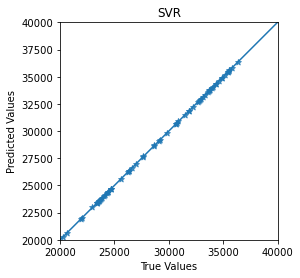

In [13]:
fig = plot_accuracy(eval_df,modeltype, f"./{modeltype}/accuracy_{namespace}")

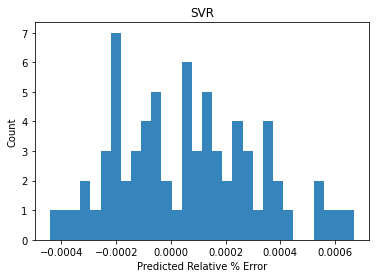

In [14]:
fig = plot_error_variations(eval_df,modeltype, f"./{modeltype}/error_variations_{namespace}")

In [15]:
abs_error_nn = abs(Y_test_predictions - data_y_test)/data_y_test*100
np.average(abs_error_nn)


0.00021651270202390974

In [16]:
r2_test = r2_score(data_y_test, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  1.00


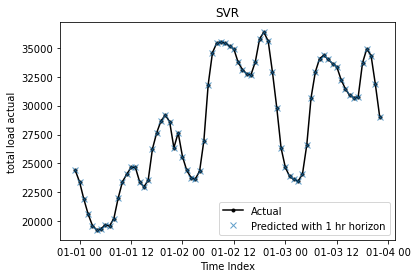

In [17]:
fig = plot_predictions(eval_df,1,modeltype,feature ,f"./{modeltype}/predictions_{namespace}")

### Multistep prediction


Loading the data set

In [18]:
%%skip $SKIP_SVM

scaled_df = base_df.copy(deep=True)

Scaling the data set

In [19]:
%%skip $SKIP_SVM

featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [20]:
%%skip $SKIP_SVM

train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature = 'total load actual'
namespace = 'MS_SVR'
modeltype = 'SVR'
feature_df = base_df[feature]
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [21]:
%%skip $SKIP_SVM

pd.options.mode.chained_assignment = None 

kernel='linear' 
gamma='scale' 
C=1
epsilon=0.1    
shrinking=True 
tol=0.00001

svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

Fitting the model to the training data

In [22]:
%%skip $SKIP_SVM

model = svr
model.fit(data_x_train, data_y_train)

In [23]:
%%skip $SKIP_SVM

y_predicted =pd.Series(dtype ='float64', index=data_y_test.index)

Model predictions

In [24]:
%%skip $SKIP_SVM

case_indices = data_y_test.index
window = 720
start_case_index = case_indices[0]-timedelta(hours=window)
end_case_index = case_indices[0]-timedelta(hours=1)
data_x_last = scaled_df[start_case_index:end_case_index]
dummy_array = np.zeros((1,data_x_last.shape[1])) 

for case_index in case_indices:

  load_prediction = svr.predict(data_x_last).flatten()[0]

  y_predicted.update(pd.Series(load_prediction,index=[case_index]))

  dummy_array[0,data_x_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,data_x_last.shape[1]-1]
  
  start_case_index = case_index-timedelta(hours=window-1)
  end_case_index=case_index

  data_x_last = scaled_df[start_case_index:end_case_index]
  data_x_last.loc[case_index,'total load actual'] = load_scaled


Model predictions

In [25]:
eval_df = create_eval_df(y_predicted,data_y_test,)

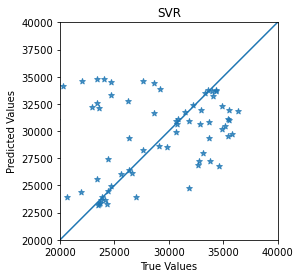

In [26]:
fig = plot_accuracy(eval_df,modeltype, f"./{modeltype}/accuracy_{namespace}")

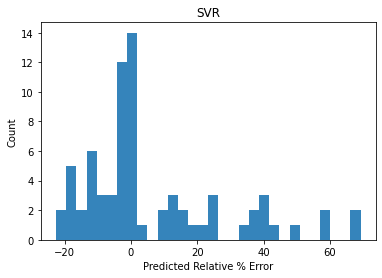

In [27]:
fig = plot_error_variations(eval_df,modeltype, f"./{modeltype}/error_variations_{namespace}")

In [28]:
abs_error_nn = abs(y_predicted - data_y_test)/data_y_test*100
np.average(abs_error_nn)


15.153299430125925

In [29]:
r2_test = r2_score(data_y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -0.09


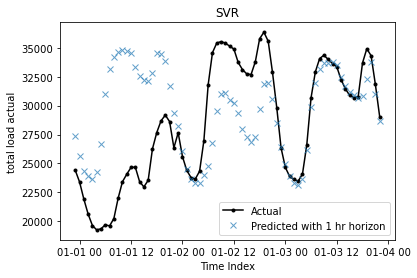

In [30]:
fig = plot_predictions(eval_df,1,modeltype,feature ,f"./{modeltype}/predictions_{namespace}")

### Conclusion